# LaLondeデータセットの分析

LaLondeデータセットは、1970年代の労働市場トレーニングプログラム（JTPA）の効果について研究するために収集されたデータセットである。
この研究は、ニュージャージー州の労働市場トレーニングプログラムに参加した人々と非参加者の労働市場成果を比較し、
トレーニングプログラムの効果を評価することを目的としている。

データセットには、以下の情報が含まれている。

- Treat: トレーニングプログラムに参加したかどうか（1 = 参加、0 = 非参加）
- Age: 参加者の年齢
- Education: 参加者の教育水準
- Black: 黒人かどうか（1 = 黒人、0 = その他の人種）
- Hispanic: ヒスパニックかどうか（1 = ヒスパニック、0 = その他の人種）
- Married: 結婚しているかどうか（1 = 結婚している、0 = 未婚）
- Nodegree: 高校卒業証書を持っているかどうか（1 = 高校卒業証書がない、0 = 高校卒業証書がある）
- RE74: 1974年の実際の収入
- RE75: 1975年の実際の収入
- RE78: 1978年の実際の収入

NSW（National Supported Work）は、LaLondeデータセットに対して一般的に使用されるプロトコルの1つであり、
非ランダム化試験の効果を評価するために使用される。NSWは、労働市場トレーニングプログラムに参加しなかった人々の代替処置群と、
労働市場トレーニングプログラムに参加した人々の処置群とを比較することで、労働市場トレーニングプログラムの効果をより正確に測定することができる。

<img src="../image/image3_7.jpg" alt="図3.7">

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Noto Sans CJK JP'

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.simplefilter("ignore")

# Load Data

NSW、CPS1、CPS3という３つのデータがある。
- NSWは、労働市場トレーニングプログラムのデータ。　　
- CPS1は、NSWの介入が行われたデータと別の調査データを非介入として組み合わせたもの。　　
- CPS3は、CPS1のデータの非介入のデータの中から特定の条件を満たさないサンプルを除外したものになっている。

In [3]:
cps1_data = pd.read_stata('https://users.nber.org/~rdehejia/data/cps_controls.dta')
cps3_data = pd.read_stata('https://users.nber.org/~rdehejia/data/cps_controls3.dta')
nswdw_data = pd.read_stata('https://users.nber.org/~rdehejia/data/nsw_dw.dta')

In [4]:
cps1_nsw_data = pd.concat([nswdw_data[nswdw_data.treat == 1], cps1_data], ignore_index=True)
cps3_nsw_data = pd.concat([nswdw_data[nswdw_data.treat == 1], cps3_data], ignore_index=True)

In [5]:
cps1_nsw_data.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898
1,Dehejia-Wahba Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043
2,Dehejia-Wahba Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219
3,Dehejia-Wahba Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996
4,Dehejia-Wahba Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886


In [6]:
cps3_nsw_data.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898
1,Dehejia-Wahba Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043
2,Dehejia-Wahba Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219
3,Dehejia-Wahba Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996
4,Dehejia-Wahba Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886


# Confirmation of Results through Randomized Controlled Trials (RCT)
NSWにおけるRCTの結果を確認する。NSWの実験データで職業訓練の収入に対する効果を推定する。
NSWの実験データで職業訓練の収入に対する効果を推定する。以下のようなモデルを仮定して回帰分析を行って、効果推定を行う


$$
earn_{78, i} = β_0 + β_1treat_i + β_2re74_i + β_3re75_i + β_4age_i + β_5educ_i + β_6black_i + β_7hispan_i + β_8nodegr_i + β_9married_i + u_i
$$

In [8]:
# 共変量なしの回帰分析
y = nswdw_data.re78
X = nswdw_data.treat
X = sm.add_constant(X)

results = sm.OLS(y, X).fit()
coef_no_control = results.summary().tables[1]
coef_no_control = pd.read_html(coef_no_control.as_html(), header=0, index_col=0)[0]
coef_no_control

,coef,std err,t,P>|t|,[0.025,0.975]
const,4554.8011,408.046,11.162,0.000,3752.855,5356.747
treat,1794.3424,632.853,2.835,0.005,550.574,3038.110


In [14]:
# 共変量付きの回帰分析
y = nswdw_data.re78
X = nswdw_data[["treat", "re74", "re75", "age", "education", "black", "hispanic", "nodegree", "married"]]

X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
coef = results.summary().tables[1]
coef = pd.read_html(coef.as_html(), header=0, index_col=0)[0]
pd.DataFrame(coef.loc['treat']).T

,coef,std err,t,P>|t|,[0.025,0.975]
treat,1676.3426,638.682,2.625,0.009,421.056,2931.629


推定された効果量は、1676となり、統計的にも有意な結果になっている。NSWの介入が行われた対象は約1600収入が上昇しているという結果を表し、職業訓練としてある程度の効果があることが確認できる。

問題は、LaLondeと同様のデータ加工を行った際に、このような結果を得られるかにある。


CPS1のデータセットは、NSWで介入が行われなかったデータの部分を、別の調査データであるCPSから介入の前々年にあたる1974年の収入が観測されている対象のデータに差し替えたもの。この調査データは特に、"失業者"のデータに限定されているわけではないので、失業者への実験データであるNSWとは含まれている人の傾向が大きく異なっている。CSPのデータを非介入グループとして組み合わせると、介入グループと非介入グループの平均的な傾向が異なっていることになる。


このまま、介入グループと非介入グループの平均を比較した場合、基本的に失業者のデータである介入グループの所得は低く、失業者以外の人からもデータを得ている非介入グループの所得は高くなる。よって、単純に平均を比較すると、セレクションバイアスの問題が入り込む。
しかし、非介入グループのデータの中には失業している人も含まれているため、介入グループと異傾向が同一であるようなサンプルも含まれる。


つまり、この部分から効果を上手く推定できれば、NSWにおける実験の結果に近い結果が得られると考えられる。

In [21]:
## CPS1の分析結果
y = cps1_nsw_data.re78
X = cps1_nsw_data[['treat', 're74', 're75', 'age', 'education', 'black', 'hispanic', 'nodegree', 'married']]
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
coef = results.summary().tables[1]
coef = pd.read_html(coef.as_html(), header=0, index_col=0)[0]
pd.DataFrame(coef.loc['treat']).T

,coef,std err,t,P>|t|,[0.025,0.975]
treat,699.1317,547.636,1.277,0.202,-374.296,1772.559


In [22]:
## CPS3の分析結果
y = cps3_nsw_data.re78
X = cps3_nsw_data[['treat', 're74', 're75', 'age', 'education', 'black', 'hispanic', 'nodegree', 'married']]
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
coef = results.summary().tables[1]
coef = pd.read_html(coef.as_html(), header=0, index_col=0)[0]
pd.DataFrame(coef.loc['treat']).T

,coef,std err,t,P>|t|,[0.025,0.975]
treat,1548.2438,781.279,1.982,0.048,13.89,3082.598


# Propensity Score Estimation

In [17]:
class PropensityScoreMatching:
    """
    ロジスティック回帰を使用して傾向スコアを推定し、最近傍法による傾向スコアマッチングを行うクラス。

    Parameters
    ----------
    bias_data : pd.DataFrame
        バイアスのあるデータ
    treatment : str
        介入変数のカラム名
    control : list
        介入変数以外の説明変数のカラム名
    random_state : int
        乱数のシード値

    Attributes
    ----------
    y : pandas.Series
        介入変数
    X : pandas.DataFrame
        介入変数以外の説明変数

    Methods
    -------
    match()
        マッチングを行う
    get_ipw()
        IPWを計算する

    Raises
    ------
    ValueError
        介入変数が0,1以外の値をとる場合
    """
    def __init__(self, bias_data, treatment, control, random_state=0):
        """
        Parameters
        ----------
        bias_data: pandas.DataFrame()
            分析に使用するデータ
        treatment: str
            介入変数のカラム名
        control: list
            介入変数以外の説明変数のカラム名
        random_state: int
            乱数のシード値
        """
        self.bias_data = bias_data
        self.treatment = treatment
        self.control = control
        self.random_state = random_state

        self.y = None
        self.X = None

    def match(self):
        """
        傾向スコアマッチングを行い、マッチしたデータを返す。

        Returns
        -------
        matched_X : pandas.DataFrame
            マッチした共変量の値を保持するデータフレーム。
        matched_y : pandas.Series
            マッチした介入変数の値を保持するシリーズ。

        Raises
        ------
        ValueError
            介入変数が0,1以外の値をとる場合
        """
        self.y = self.bias_data[self.treatment].copy()
        self.X = self.bias_data[self.control].copy()

        object_columns = self.X.select_dtypes(include="object").columns.tolist()
        if len(object_columns)>0:
            self.X = pd.get_dummies(self.X, columns=object_columns, drop_first=True)

        ps_model = LogisticRegression(solver="lbfgs", random_state=self.random_state)
        ps_model.fit(self.X, self.y)
        ps_score = ps_model.predict_proba(self.X)[:, 1]
        all_df = pd.DataFrame({f"{self.treatment}": self.y, "ps_score": ps_score})

        treatments = all_df[self.treatment].unique()

        if len(treatments) != 2:
            print("Matching can only be performed for two groups. Please represent the two groups as [0, 1].")
            raise ValueError

        group1_df = all_df[all_df[self.treatment]==1].copy()
        group1_indices = group1_df.index
        group1_df = group1_df.reset_index(drop=True)

        group0_df = all_df[all_df[self.treatment]==0].copy()
        group0_indices = group0_df.index
        group0_df = group0_df.reset_index(drop=True)

        # The recommended standard deviation of the logit-transformed propensity score estimate is multiplied by 0.2.
        threshold = all_df["ps_score"].std() * 0.2

        matched_group1_dfs = []
        matched_group0_dfs = []
        _group1_df = group1_df.copy()
        _group0_df = group0_df.copy()

        while True:
            nearest_neighbor_model = NearestNeighbors(n_neighbors=1)
            nearest_neighbor_model.fit(_group1_df["ps_score"].values.reshape(-1, 1))
            distances, indices = nearest_neighbor_model.kneighbors(_group0_df["ps_score"].values.reshape(-1, 1))

            distance_df = pd.DataFrame({"distance": distances.reshape(-1), "indices": indices.reshape(-1)})
            distance_df.index = _group0_df.index
            distance_df = distance_df.drop_duplicates(subset="indices")

            distance_df = distance_df[distance_df["distance"] < threshold]

            if len(distance_df) == 0:
                break

            group1_matched_indices = _group1_df.iloc[distance_df['indices']].index.tolist()
            group0_matched_indices = distance_df.index
            matched_group1_dfs.append(_group1_df.loc[group1_matched_indices])
            matched_group0_dfs.append(_group0_df.loc[group0_matched_indices])
            _group1_df = _group1_df.drop(group1_matched_indices)
            _group0_df = _group0_df.drop(group0_matched_indices)

        # マッチしたレコードを返す
        group1_df.index = group1_indices
        group0_df.index = group0_indices
        matched_df = pd.concat([
            group1_df.iloc[pd.concat(matched_group1_dfs).index],
            group0_df.iloc[pd.concat(matched_group0_dfs).index]
        ]).sort_index()
        matched_indices = matched_df.index

        return self.X.loc[matched_indices], self.y.loc[matched_indices]

    def get_ipw(self):
        """
        IPWを計算する

        Returns
        -------
        weights: pandas.Series
            IPWの値を保持するシリーズ
        """
        self.y = self.bias_data[self.treatment].copy()
        self.X = self.bias_data[self.control].copy()

        object_columns = self.X.select_dtypes(include="object").columns.tolist()
        if len(object_columns)>0:
            self.X = pd.get_dummies(self.X, columns=object_columns, drop_first=True)

        ps_model = LogisticRegression(solver="lbfgs", random_state=self.random_state)
        ps_model.fit(self.X, self.y)
        ps_score = ps_model.predict_proba(self.X)[:, 1]
        all_df = pd.DataFrame({f"{self.treatment}": self.y, "ps_score": ps_score})

        treatments = all_df[self.treatment].unique()

        if len(treatments) != 2:
            print("Matching can only be performed for two groups. Please represent the two groups as [0, 1].")
            raise ValueError

        group1_df = all_df[all_df[self.treatment]==1].copy()
        group0_df = all_df[all_df[self.treatment]==0].copy()

        group1_df['weight'] = 1 / group1_df.ps_score
        group0_df['weight'] = 1 / (1 - group0_df.ps_score)
        weights = pd.concat([group1_df, group0_df]).sort_index()['weight'].values

        return weights

In [52]:

ps_match_model = PropensityScoreMatching(cps1_nsw_data, treatment="treat", control=['age', 'education', 'black', 'hispanic', 'nodegree', 'married', 're74', 're75'], random_state=0)
matchX, matchy = ps_match_model.match()

# マッチング後のデータ作成
matched_data = cps1_nsw_data.loc[matchX.index]
# マッチング後のデータで効果の推定
y = matched_data.re78
X = matched_data[['treat']]
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
coef = results.summary().tables[1]
coef = pd.read_html(coef.as_html(), header=0, index_col=0)[0]
pd.DataFrame(coef.loc['treat']).T

,coef,std err,t,P>|t|,[0.025,0.975]
treat,462.5962,791.565,0.584,0.559,-1094.554,2019.746


結構下ぶれが起きてしまっている。共変量の選択を色々変えると値が大きく変わるので、共変量の選択が重要になってくる？

In [40]:
import itertools
from tqdm import tqdm

lst = ['age', 'education', 'black', 'hispanic', 'nodegree', 'married', 're74', 're75']
combinations = [list(subset) for i in range(2, len(lst) + 1) for subset in itertools.combinations(lst, i)]

print(len(combinations))

247


In [43]:
coef_list = []

for combination in tqdm(combinations):
    ps_match_model = PropensityScoreMatching(cps1_nsw_data, treatment="treat", control=combination, random_state=0)
    matchX, matchy = ps_match_model.match()

    # マッチング後のデータ作成
    matched_data = cps1_nsw_data.loc[matchX.index]
    # マッチング後のデータで効果の推定
    y = matched_data.re78
    X = matched_data[['treat']]
    X = sm.add_constant(X)
    results = sm.OLS(y, X).fit()
    coef = results.summary().tables[1]
    coef = pd.read_html(coef.as_html(), header=0, index_col=0)[0]
    coef_list.append(pd.DataFrame(coef.loc['treat']).T["coef"][0])

    # もしtreatが1100~1800の範囲にあれば、共変量と値を出力する
    if 1100 < pd.DataFrame(coef.loc['treat']).T["coef"][0] < 1800:
        print(combination)
        print(pd.DataFrame(coef.loc['treat']).T["coef"][0])


 30%|██▉       | 74/247 [00:18<00:37,  4.61it/s]

['black', 'married', 're75']
1297.9212


 45%|████▍     | 110/247 [00:24<00:21,  6.34it/s]

['age', 'black', 're74', 're75']
1242.1474


 52%|█████▏    | 129/247 [00:27<00:26,  4.53it/s]

['education', 'black', 're74', 're75']
1112.3849


 59%|█████▊    | 145/247 [00:31<00:21,  4.72it/s]

['black', 'hispanic', 'married', 're75']
1111.2411


 64%|██████▍   | 159/247 [00:33<00:11,  7.86it/s]

['age', 'education', 'black', 'hispanic', 're75']
1302.8826


 74%|███████▍  | 183/247 [00:36<00:09,  6.41it/s]

['age', 'black', 'nodegree', 'married', 're75']
1371.6138


 75%|███████▍  | 185/247 [00:36<00:09,  6.78it/s]

['age', 'black', 'married', 're74', 're75']
1514.98


 77%|███████▋  | 189/247 [00:37<00:08,  6.77it/s]

['age', 'nodegree', 'married', 're74', 're75']
1322.8409


 81%|████████  | 199/247 [00:39<00:09,  4.96it/s]

['education', 'black', 'nodegree', 're74', 're75']
1752.0518


 87%|████████▋ | 216/247 [00:43<00:04,  6.30it/s]

['age', 'education', 'black', 'hispanic', 'married', 're75']
1239.9124


 89%|████████▊ | 219/247 [00:43<00:04,  6.17it/s]

['age', 'education', 'black', 'nodegree', 'married', 're75']
1192.1645
['age', 'education', 'black', 'nodegree', 're74', 're75']
1235.5258


 93%|█████████▎| 230/247 [00:45<00:02,  5.95it/s]

['age', 'black', 'hispanic', 'married', 're74', 're75']
1709.3024


 95%|█████████▌| 235/247 [00:46<00:02,  5.04it/s]

['education', 'black', 'hispanic', 'nodegree', 're74', 're75']
1357.9106


 96%|█████████▌| 236/247 [00:46<00:02,  4.69it/s]

['education', 'black', 'nodegree', 'married', 're74', 're75']
1217.4321


 98%|█████████▊| 243/247 [00:47<00:00,  6.50it/s]

['age', 'education', 'black', 'hispanic', 'married', 're74', 're75']
1194.591


100%|██████████| 247/247 [00:48<00:00,  5.11it/s]

['education', 'black', 'hispanic', 'nodegree', 'married', 're74', 're75']
1208.0128


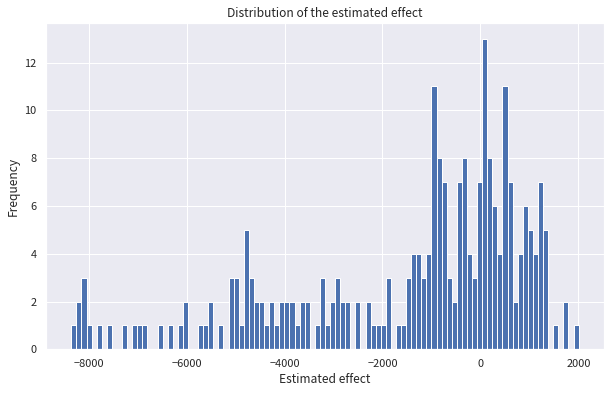

In [45]:
# 傾向スコアマッチングの推定結果を可視化する
plt.figure(figsize=(10, 6))
plt.hist(coef_list, bins=100)
plt.title("Distribution of the estimated effect")
plt.xlabel("Estimated effect")
plt.ylabel("Frequency")
plt.show()

推定値がマイナスな値があるが、これは実装がおかしいのか？

## 共変量のバランスを確認

In [46]:
ps_match_model = PropensityScoreMatching(cps1_nsw_data, treatment="treat", control=['age', 'education', 'black', 'hispanic', 'nodegree', 'married', 're74', 're75'], random_state=0)
matchX, matchy = ps_match_model.match()

# マッチング後のデータ作成
matched_data = cps1_nsw_data.loc[matchX.index]
# マッチング後のデータで効果の推定
y = matched_data.re78
X = matched_data[['treat']]
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
coef = results.summary().tables[1]
coef = pd.read_html(coef.as_html(), header=0, index_col=0)[0]
pd.DataFrame(coef.loc['treat']).T

,coef,std err,t,P>|t|,[0.025,0.975]
treat,462.5962,791.565,0.584,0.559,-1094.554,2019.746


In [47]:
def calc_absolute_mean_difference(df):
    # (treatment群の平均 - control群の平均) / 全体の標準誤差
    return ((df[df.treat==1].drop('treat', axis=1).mean() - df[df.treat==0].drop('treat', axis=1).mean()) \
            / df.drop('treat', axis=1).std()).abs()

## 調整前のAbsolute Mean Difference
unadjusted_df = cps1_nsw_data[['treat', 'age', 'education', 'black', 'hispanic', 'nodegree', 'married', 're74', 're75']]
unadjusted_amd = calc_absolute_mean_difference(unadjusted_df)

# 傾向スコアマッチング後のAbusolute Mean Difference
after_matching_df = cps1_nsw_data.loc[matchX.index][['treat', 'age', 'education', 'black', 'hispanic', 'nodegree', 'married', 're74', 're75']]
after_matching_amd = calc_absolute_mean_difference(after_matching_df)

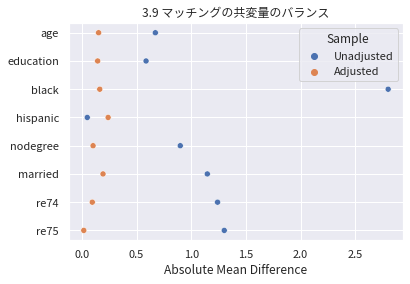

In [49]:
balance_df = pd.concat([
    pd.DataFrame({'Absolute Mean Difference': unadjusted_amd, 'Sample': 'Unadjusted'}),
    pd.DataFrame({'Absolute Mean Difference': after_matching_amd, 'Sample': 'Adjusted'})
])


fig = sns.scatterplot(data=balance_df, x='Absolute Mean Difference', y=balance_df.index, hue="Sample")
fig.set_title('3.9 マッチングの共変量のバランス')
plt.show()

# Inverse Probability Weighting(IPW)

In [53]:
ps_score_model = PropensityScoreMatching(cps1_nsw_data, treatment="treat", control=['age', 'education', 'black', 'hispanic', 'nodegree', 'married', 're74', 're75'], random_state=0)

weights = ps_score_model.get_ipw()

In [32]:
X = cps1_nsw_data[['age', 'education', 'black', 'hispanic', 'nodegree', 'married', 're74', 're75']]
y = cps1_nsw_data['treat']
weights = get_ipw(X, y)

In [54]:
## 重み付きデータでの効果の推定
y = cps1_nsw_data.re78
X = cps1_nsw_data.treat
X = sm.add_constant(X)
results = sm.WLS(y, X, weights=weights).fit()
coef = results.summary().tables[1]
coef = pd.read_html(coef.as_html(), header=0, index_col=0)[0]
coef

,coef,std err,t,P>|t|,[0.025,0.975]
const,14710.0000,87.60,167.886,0.0,14500.000,14900.000
treat,-7343.8457,139.36,-52.697,0.0,-7617.007,-7070.684


分析結果が-7343となり、統計的にも有意となっている。仮にNSWの実験結果を知らず、IPWの分析結果しか見ていなければ、職業訓練には大きな負の効果があると報告されてしまう。

介入グループと非介入グループの傾向の違いが大きい場合、IPWの分析結果は信頼しにくいことが知られている。
<I>これは、傾向スコアの逆数をサンプルの重みに利用している特性上、傾向スコアが非常に小さい値を取ると、そのサンプルの重みが大きくなってしまうことが原因である。</I>

例：傾向のスコアの値が0.01%の場合、IPWではそのサンプルは10000倍に水増しされてしまう。（傾向スコアの推定に小さな誤差があるだけでも、推定効果に大きな影響を受けることになる）このような状況では、傾向スコアの推定に非常に小さな誤差があるだけでも効果の推定結果に大きな影響を受けることになる。

今回、傾向スコアが大きな負の値になってしまった。今回のデータの場合、CPSにしか含まれないようなサンプルの重みが大きな値を取ることになる。そして、そのようなサンプルは、職業訓練を必要としなもともとの収入が暗転しているサンプルであるため、期待値の推定結果が非常に大きくなり、結果として、効果の推定値が大きく負の値になってしまう
。

介入もしくは非介入のグループにしか存在しないようなサンプルがある場合、傾向スコアは0か1に非常に近い値を取ることになり、傾向スコアで分析できる対象を大きく制限することになる。

## check balance

In [55]:
# IPWで重み付け後のAbsolute Mean Difference
# 重みのぶんレコードを増やして計算する（もっといいやり方を知りたい）
after_weighted_df = cps1_nsw_data.loc[matchX.index][['treat', 'age', 'education', 'black', 'hispanic', 'nodegree', 'married', 're74', 're75']]
weights_int = (weights * 100).astype(int)
weighted_df = []
for i, value in enumerate(after_weighted_df.values):
    weighted_df.append(np.tile(value, (weights_int[i], 1)))
weighted_df = np.concatenate(weighted_df).reshape(-1, 9)
weighted_df = pd.DataFrame(weighted_df)
weighted_df.columns = after_weighted_df.columns
after_weighted_amd = calc_absolute_mean_difference(weighted_df)

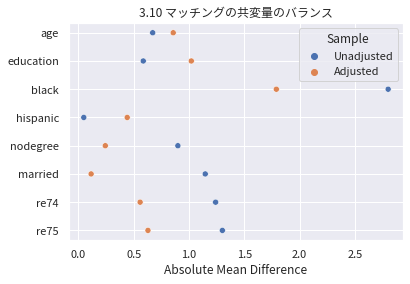

In [56]:
balance_df = pd.concat([
    pd.DataFrame({'Absolute Mean Difference': unadjusted_amd, 'Sample': 'Unadjusted'}),
    pd.DataFrame({'Absolute Mean Difference': after_weighted_amd, 'Sample': 'Adjusted'})
])
fig = sns.scatterplot(data=balance_df, x='Absolute Mean Difference', y=balance_df.index, hue="Sample")
fig.set_title('3.10 マッチングの共変量のバランス')
plt.show()